### PART A: What Predicts the Long-Term Home Price Appreciation of a City?

In [1]:
#Import libraries.
import os
import numpy as np
from numpy import argmax
import pandas as pd
import matplotlib.pyplot as plt
import missingno as ms
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn.discriminant_analysis as DA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Set working directory. 
os.chdir("C:/Users/alexm/OneDrive/Desktop/UCLA Data Science Certification/Week 2/Script & Data Week 2")

In [4]:
#Import homeprice data set.
homeprice = pd.read_excel('W02b_homeprice.xlsx')

In [6]:
homeprice.head()

,MSA (Metropolitan Statistical Area),homepriceg,bpo_pop03,pincomeg,chci,jante,ocean,unaval,pop03
0,"Abilene, TX (Metropolitan Statistical Area)",66.3,3.4,108.8,126.0,44.0,0,2.0,158810
1,"Akron, OH (Metropolitan Statistical Area)",28.6,5.8,75.9,133.1,26.0,0,6.5,701139
2,"Albany, GA (Metropolitan Statistical Area)",45.4,6.8,77.3,124.1,51.0,0,12.7,156914
3,"Albany-Schenectady-Troy, NY (Metropolitan Stat...",86.6,4.6,98.5,136.1,25.0,0,23.3,844619
4,"Albuquerque, NM (Metropolitan Statistical Area)",49.4,11.7,111.6,131.2,35.0,0,11.6,772128


In [8]:
homeprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MSA (Metropolitan Statistical Area)  245 non-null    object 
 1   homepriceg                           245 non-null    float64
 2   bpo_pop03                            245 non-null    float64
 3   pincomeg                             245 non-null    float64
 4   chci                                 245 non-null    float64
 5   jante                                245 non-null    float64
 6   ocean                                245 non-null    int64  
 7   unaval                               245 non-null    float64
 8   pop03                                245 non-null    int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 17.4+ KB


In [10]:
homeprice = homeprice.rename(columns = {'MSA (Metropolitan Statistical Area)': 'MSA'})

In [11]:
homeprice.describe()

,homepriceg,bpo_pop03,pincomeg,chci,jante,ocean,unaval,pop03
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,2.450000e+02
mean,63.760816,9.411429,109.571429,129.966939,35.578776,0.155102,25.187755,8.926241e+05
std,25.002772,5.677229,32.240550,5.638459,12.767847,0.362743,20.912086,1.804732e+06
min,1.300000,1.800000,27.600000,109.000000,6.000000,0.000000,0.500000,6.824600e+04
25%,47.900000,5.500000,88.700000,126.800000,25.700000,0.000000,9.100000,1.842540e+05
50%,61.500000,8.300000,107.800000,130.200000,33.000000,0.000000,18.500000,3.524110e+05
75%,75.300000,12.000000,130.000000,133.100000,45.000000,0.000000,38.000000,7.222740e+05
max,149.500000,39.700000,215.800000,146.900000,68.000000,1.000000,86.000000,1.859880e+07


In [15]:
#Plot a correlation chart for all variables in homeprice data set.
cor = homeprice.corr()
cor

,homepriceg,bpo_pop03,pincomeg,chci,jante,ocean,unaval,pop03
homepriceg,1.000000,-0.169263,0.221915,0.345146,0.000297,0.429371,0.379212,0.246449
bpo_pop03,-0.169263,1.000000,0.622337,0.108032,0.304514,0.138244,0.085852,-0.039654
pincomeg,0.221915,0.622337,1.000000,0.029674,0.371005,0.152750,0.016972,0.044817
chci,0.345146,0.108032,0.029674,1.000000,-0.386540,0.157209,0.076813,0.108757
jante,0.000297,0.304514,0.371005,-0.386540,1.000000,0.341931,0.320524,0.114709
ocean,0.429371,0.138244,0.152750,0.157209,0.341931,1.000000,0.565540,0.312211
unaval,0.379212,0.085852,0.016972,0.076813,0.320524,0.565540,1.000000,0.107429
pop03,0.246449,-0.039654,0.044817,0.108757,0.114709,0.312211,0.107429,1.000000


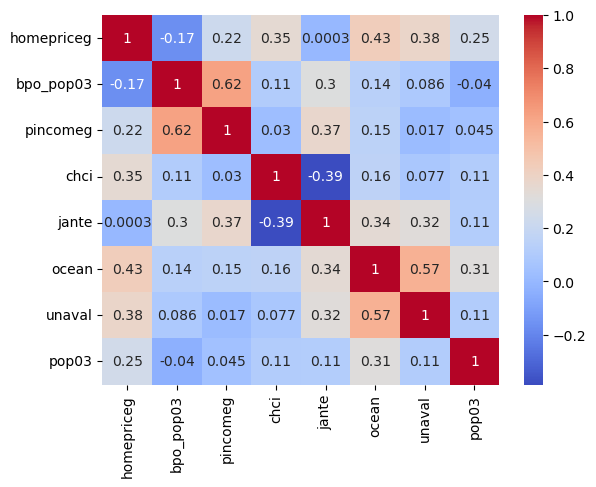

In [16]:
sns.heatmap(cor, annot = True, cmap = 'coolwarm') #colorize correlation chart.
plt.show() #The pincomeg and bpo_pop03 variables have a correlation coefficient of 0.62.
#The unaval and ocen variables have a correlation coefficient of 0.57.

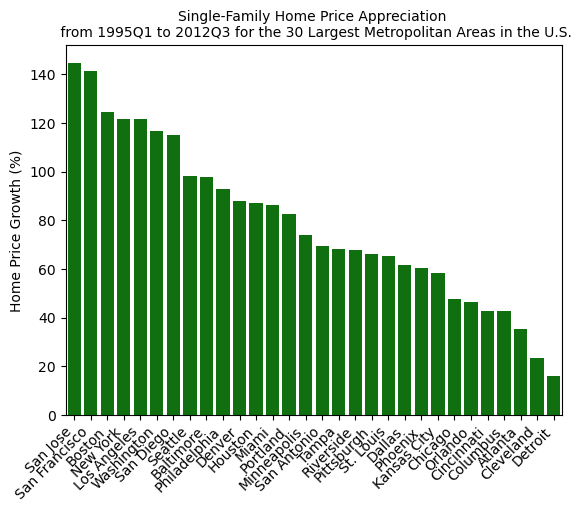

In [36]:
#Replicate Figures 1 and 5 from the "R02_What Predicts the Long-term Home Price Appreciation of a City?" article. 

#Plot Figure 1.

big_cities = homeprice.sort_values('pop03', ascending = False)[:30]
big_cities["MSA"] = [i.replace('(Metropolitan Statistical Area)', '') for i in big_cities.MSA]
big_cities["MSA"] = big_cities["MSA"].str.split('-|,').str[0] 

sns.barplot(x = "MSA", y = "homepriceg", data = big_cities, color = "g", order = big_cities.sort_values('homepriceg', ascending = False).MSA)
plt.title("Single-Family Home Price Appreciation \n from 1995Q1 to 2012Q3 for the 30 Largest Metropolitan Areas in the U.S.", size = 10)
plt.xlabel("")
plt.ylabel("Home Price Growth (%)", size = 10)
plt.xticks(fontsize = 10, rotation = 45, horizontalalignment = 'right')
plt.yticks(fontsize = 10)
plt.show()

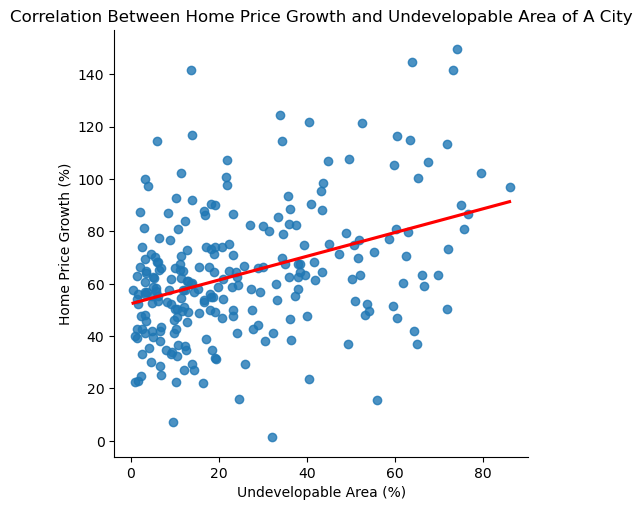

In [37]:
#Plot Figure 5.
sns.lmplot(x = "unaval", y = "homepriceg", data = homeprice, line_kws={'color': 'red'}, ci = None)
plt.xlabel("Undevelopable Area (%)")
plt.ylabel("Home Price Growth (%)")
plt.title("Correlation Between Home Price Growth and Undevelopable Area of A City")
plt.show()

In [39]:
#Replicate the linear regression model shown in Table 2 of the article.
x = homeprice[['bpo_pop03', 'pincomeg', 'chci', 'jante', 'ocean', 'unaval', 'pop03']]
y = homeprice['homepriceg']
X = sm.add_constant(x)
eq01 = sm.OLS(y, X).fit()
print(eq01.summary()) #Adjusted R^2 is 0.535. 

                            OLS Regression Results                            
Dep. Variable:             homepriceg   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     41.03
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           1.51e-37
Time:                        21:51:15   Log-Likelihood:                -1038.5
No. Observations:                 245   AIC:                             2093.
Df Residuals:                     237   BIC:                             2121.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -128.7747     31.740     -4.057      0.0

In [40]:
#Make in-sample prediction of the linear regression model. 
pred01 = eq01.predict(X)
print(pred01) #Predictions match Yhat values calculated in the "matrix_multiplication" tab in the W02b data file.

0      60.465221
1      54.764984
2      37.974214
3      77.858701
4      53.209731
         ...    
240    17.363913
241    51.121963
242    33.656867
243    47.871142
244    39.344954
Length: 245, dtype: float64


### PART B: Logistic Regression - Churn Analysis

In [3]:
#Set working directory. 
os.chdir("C:/Users/alexm/OneDrive/Desktop/UCLA Data Science Certification/Week 4/Script & Data Week 4/Script & Data Week 4")

#Import churn data set. 
churn = pd.read_csv('W04a_churn.csv')

In [4]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
churn.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
churn.shape

(7043, 21)

In [8]:
#Data Cleaning. 
print(churn.isna().sum()) #0 missing values in TotalCharges.
print(churn.duplicated().sum()) #No duplicated values.

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
0


In [9]:
#Change TotalCharges variable to numeric type.
print(churn.nunique()) #High number of unique values denote continuous data (vs. categorical data).
churn.TotalCharges = pd.to_numeric(churn.TotalCharges, errors = 'coerce')
print(churn.isna().sum()) #Now there are 11 missing values in TotalCharges.
churn = churn.dropna()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Ch

In [10]:
#Change SeniorCitizen to categorical type.
churn['SeniorCitizen'] = churn['SeniorCitizen'].astype('object')

In [11]:
#Drop customerID variable. 
churn.drop(labels = 'customerID', axis = 1, inplace = True) #inplace = True ensures change is permanent in the dataframe.

Text(0.5, 1.0, 'Churn Percentage')

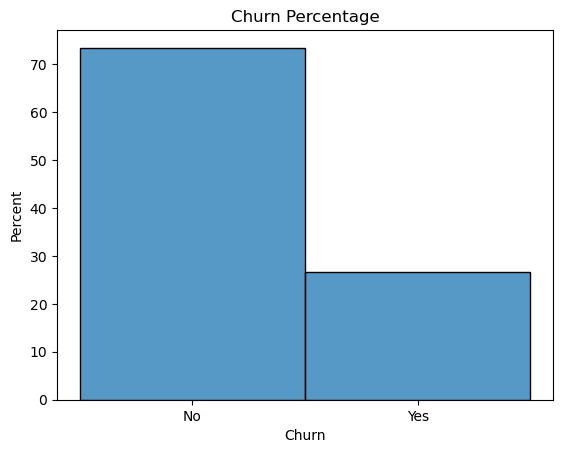

In [12]:
#Exploratory Data Analysis.

#Churn percentage.
sns.histplot(data = churn, x = 'Churn', stat = 'percent')
plt.title('Churn Percentage')

Text(0.5, 0.98, 'Churn Against Categorical Variable Plots')

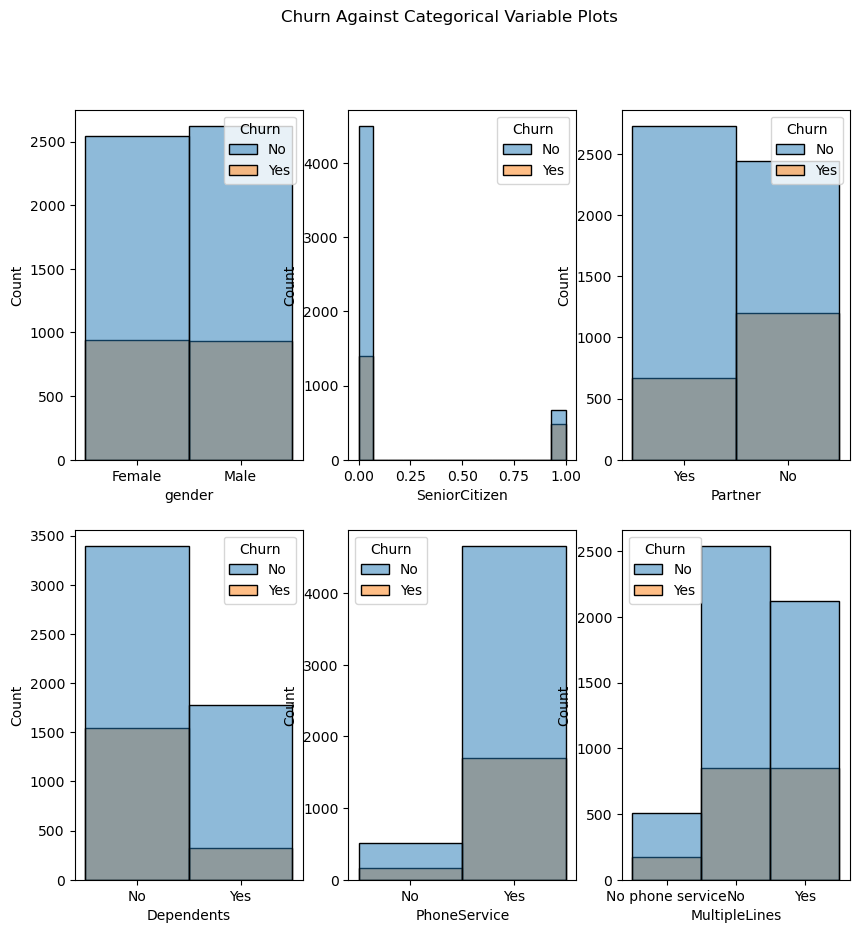

In [13]:
#Churn against categorical variables. 
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 10))
sns.histplot(data = churn, x = "gender", hue = 'Churn', ax = axes[0, 0])
sns.histplot(data = churn, x = "SeniorCitizen", hue = 'Churn', ax = axes[0, 1])
sns.histplot(data = churn, x = "Partner", hue = 'Churn', ax = axes[0, 2])
sns.histplot(data = churn, x = "Dependents", hue = 'Churn', ax = axes[1, 0])
sns.histplot(data = churn, x = "PhoneService", hue = 'Churn', ax = axes[1, 1])
sns.histplot(data = churn, x = "MultipleLines", hue = 'Churn', ax = axes[1, 2])
fig.suptitle("Churn Against Categorical Variable Plots")

Text(0.5, 0.98, 'Churn Against Categorical Variable Plots')

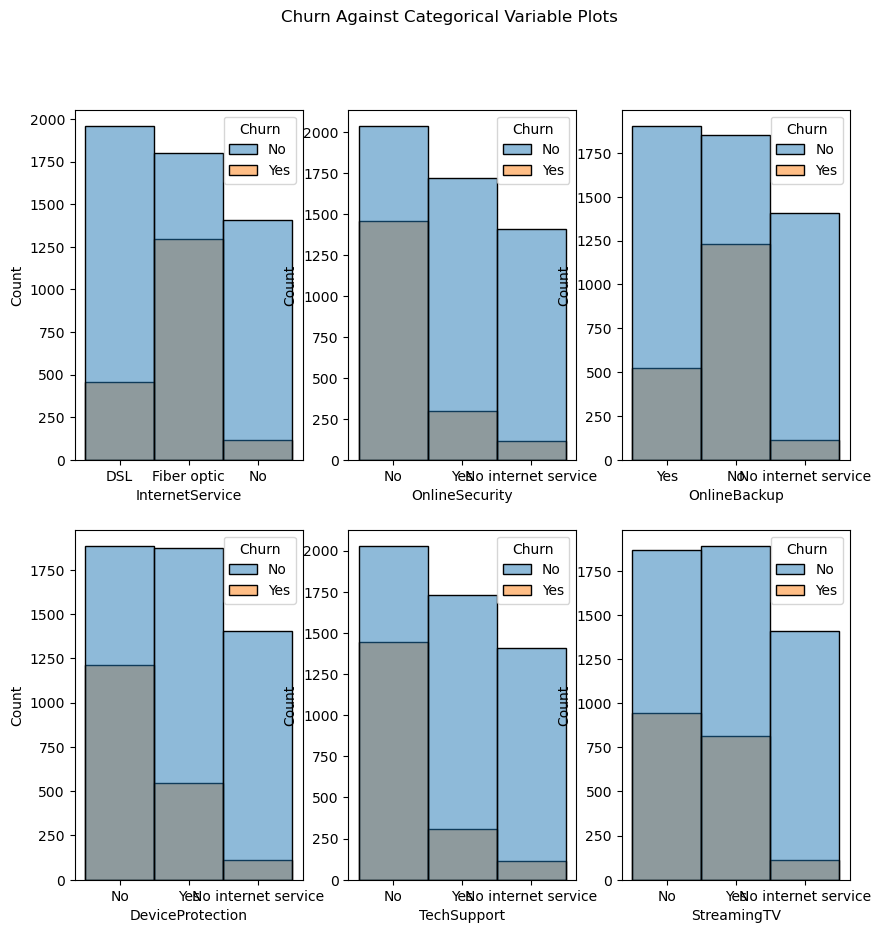

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 10))
sns.histplot(data = churn, x = "InternetService", hue = 'Churn', ax = axes[0, 0])
sns.histplot(data = churn, x = "OnlineSecurity", hue = 'Churn', ax = axes[0, 1])
sns.histplot(data = churn, x = "OnlineBackup", hue = 'Churn', ax = axes[0, 2])
sns.histplot(data = churn, x = "DeviceProtection", hue = 'Churn', ax = axes[1, 0])
sns.histplot(data = churn, x = "TechSupport", hue = 'Churn', ax = axes[1, 1])
sns.histplot(data = churn, x = "StreamingTV", hue = 'Churn', ax = axes[1, 2])
fig.suptitle("Churn Against Categorical Variable Plots")

Text(0.5, 0.98, 'Churn Against Categorical Variable Plots')

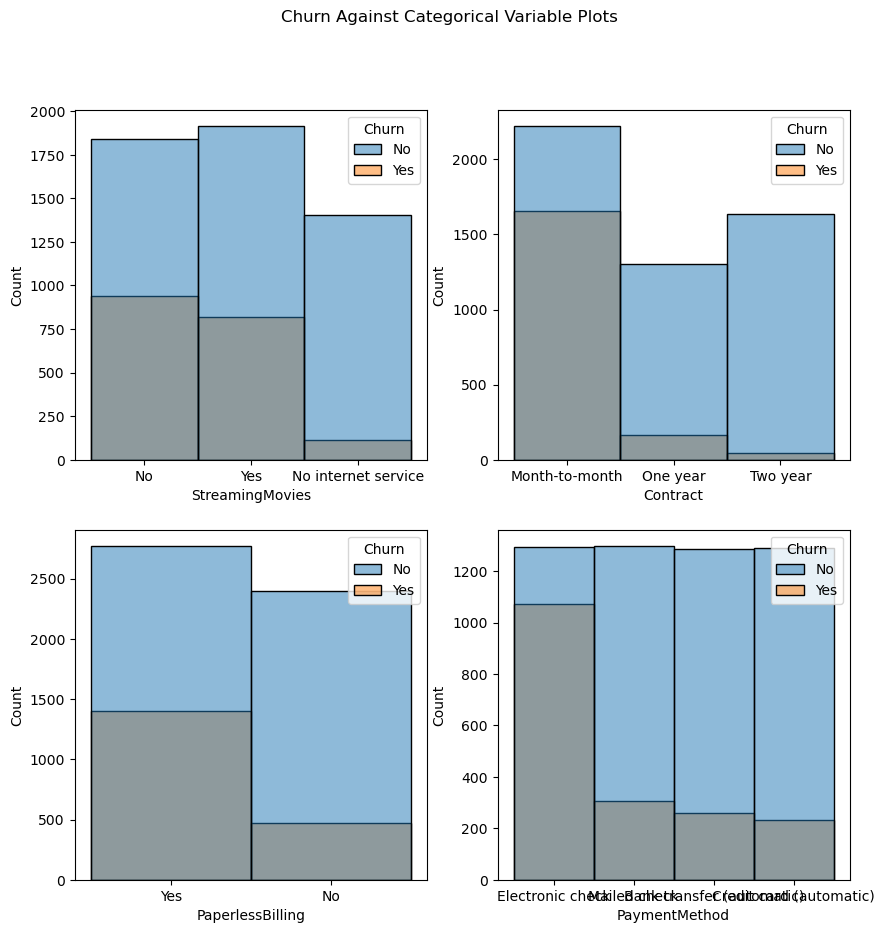

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))
sns.histplot(data = churn, x = "StreamingMovies", hue = 'Churn', ax = axes[0, 0])
sns.histplot(data = churn, x = "Contract", hue = 'Churn', ax = axes[0, 1])
sns.histplot(data = churn, x = "PaperlessBilling", hue = 'Churn', ax = axes[1, 0])
sns.histplot(data = churn, x = "PaymentMethod", hue = 'Churn', ax = axes[1, 1])
fig.suptitle("Churn Against Categorical Variable Plots")

Text(0.5, 0.98, 'Churn Against Numeric Variable Plots')

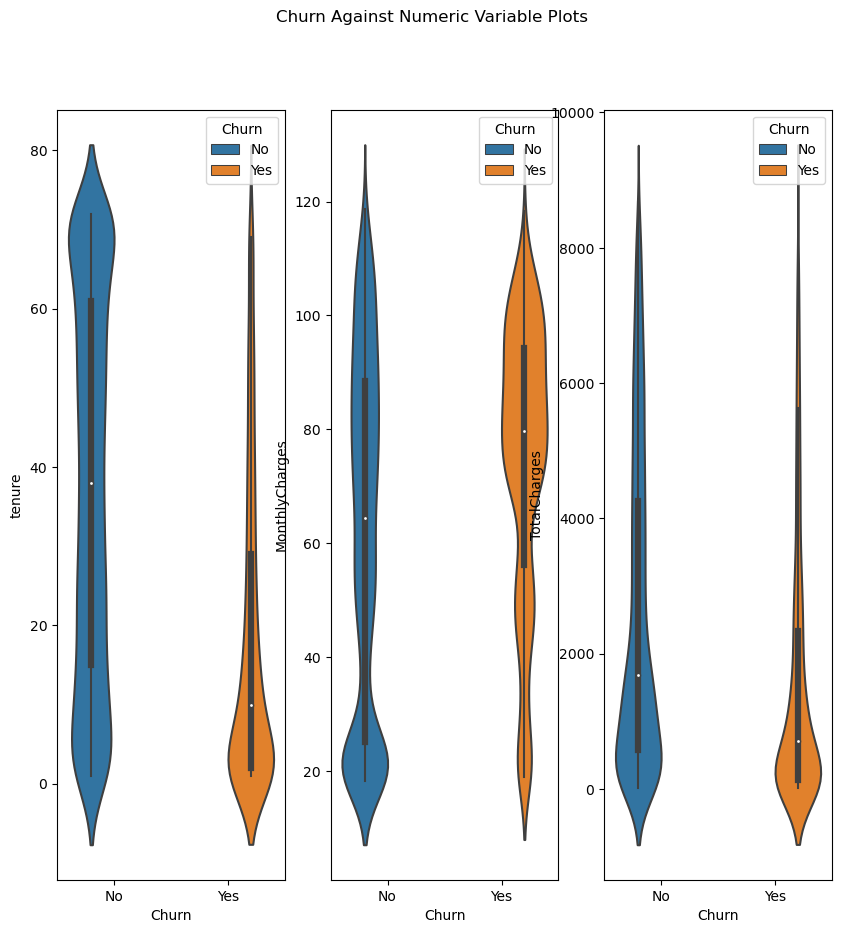

In [16]:
#Churn against numeric variables. 
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
sns.violinplot(data = churn, x = "Churn", y = "tenure", hue = "Churn", ax = axes[0])
sns.violinplot(data = churn, x = "Churn", y = "MonthlyCharges", hue = "Churn", ax = axes[1])
sns.violinplot(data = churn, x = "Churn", y = "TotalCharges", hue = "Churn", ax = axes[2])
fig.suptitle("Churn Against Numeric Variable Plots")

In [17]:
#Run logistic regression models for the churn data set.

#Convert categorical variables to dummy variables before running models.
cat_cols = [col for col in churn.columns if churn[col].dtype == 'object'] #Get categorical columns in churn data set.
cat_cols.remove("Churn")
dummies = pd.get_dummies(churn[cat_cols], drop_first = True) #Turn categorical variables into dummy variables.
churn = pd.concat([churn, dummies], axis = 1) #Concatenate churn data set with dummy variables.
churn.drop(columns = cat_cols, inplace = True) #Drop original categorical columns from data set. 

In [18]:
churn['Churn'] = churn['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) #Change Churn variable to a binary variable of integer type.

In [19]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7032 non-null   int64  
 1   MonthlyCharges                         7032 non-null   float64
 2   TotalCharges                           7032 non-null   float64
 3   Churn                                  7032 non-null   int64  
 4   gender_Male                            7032 non-null   uint8  
 5   SeniorCitizen_1                        7032 non-null   uint8  
 6   Partner_Yes                            7032 non-null   uint8  
 7   Dependents_Yes                         7032 non-null   uint8  
 8   PhoneService_Yes                       7032 non-null   uint8  
 9   MultipleLines_No phone service         7032 non-null   uint8  
 10  MultipleLines_Yes                      7032 non-null   uint8  
 11  Inte

In [20]:
y1 = churn['Churn']
x1 = churn.drop(['Churn'], axis = 1) #Run all independent variables.
X1 = sm.add_constant(x1)
logit = sm.Logit(y1, X1)
eq02 = logit.fit()
print(eq02.summary()) #Pseudo R^2 is 0.2845. 

Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7008
Method:                           MLE   Df Model:                           23
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:                  0.2845
Time:                        21:57:46   Log-Likelihood:                -2913.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.8340      

In [21]:
y2 = churn['Churn']
x2 = churn.drop(['Churn', 'MonthlyCharges'], axis = 1) #Run all independent variables except for MonthlyCharges.
X2 = sm.add_constant(x2)
logit = sm.Logit(y2, X2)
eq03 = logit.fit()
print(eq03.summary()) #Pseudo R^2 is 0.2843.

Optimization terminated successfully.
         Current function value: 0.414383
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7009
Method:                           MLE   Df Model:                           22
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:                  0.2843
Time:                        21:58:22   Log-Likelihood:                -2913.9
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.1101      

In [22]:
y3 = churn['Churn']
x3 = churn.drop(['Churn', 'TotalCharges'], axis = 1) #Run all independent variables except for TotalCharges.
X3 = sm.add_constant(x3)
logit = sm.Logit(y3, X3)
eq04 = logit.fit()
print(eq04.summary()) #Pseudo R^2 is 0.2817.

Optimization terminated successfully.
         Current function value: 0.415889
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7009
Method:                           MLE   Df Model:                           22
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:                  0.2817
Time:                        21:58:24   Log-Likelihood:                -2924.5
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.4600      

In [23]:
y4 = churn['Churn']
x4 = churn.drop(['Churn', 'PhoneService_Yes'], axis = 1) #Run all independent variables except for PhoneService_Yes.
X4 = sm.add_constant(x4)
logit = sm.Logit(y4, X4)
eq05 = logit.fit()
print(eq05.summary()) #Pseudo R^2 is 0.2845. 

Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7008
Method:                           MLE   Df Model:                           23
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:                  0.2845
Time:                        21:58:29   Log-Likelihood:                -2913.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     1.3368      

In [24]:
#The two best models I found were using all the independent variables and using all the independent variables except for PhoneService_Yes.
#For both of these models, I got a pseudo R^2 of 0.2845. These are saved in variables eq02 and eq05 respectively.

In [27]:
#Show in-sample predicted probability of churn for each sammple using default threshold of 0.5.

#Model 1:
pred01 = eq02.predict(X1)
print(pred01)
pred01_b = np.where(pred01 >= 0.5, 1, 0)
print(pred01_b)

#Model 2:
pred02 = eq05.predict(X4)
print(pred02)
pred02_b = np.where(pred02 >= 0.5, 1, 0)
print(pred02_b)

0       0.641698
1       0.039259
2       0.302001
3       0.027031
4       0.691571
          ...   
7038    0.116007
7039    0.146407
7040    0.428284
7041    0.704516
7042    0.046943
Length: 7032, dtype: float64
[1 0 0 ... 0 1 0]
0       0.641698
1       0.039259
2       0.302001
3       0.027031
4       0.691571
          ...   
7038    0.116007
7039    0.146407
7040    0.428284
7041    0.704516
7042    0.046943
Length: 7032, dtype: float64
[1 0 0 ... 0 1 0]


Confusion Matrix:
 [[4639  833]
 [ 524 1036]]


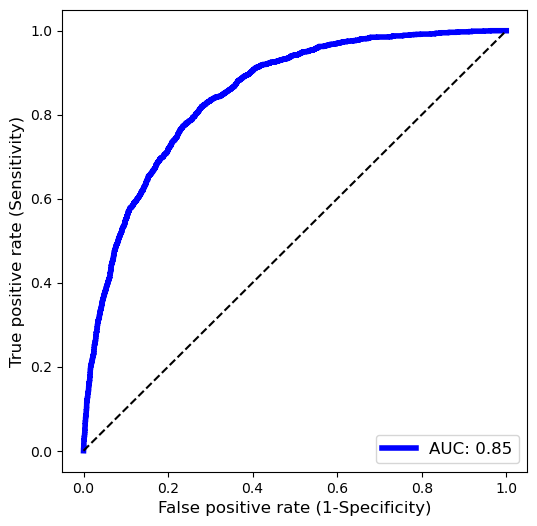

Accuracy: 0.807, Precision: 0.664, Recall: 0.554, F1: 0.604


In [32]:
#Show confusion matrix, ROC curve, accuracy, precision, recall, and F1 for both models.

#Model 1:
#Confusion matrix:
confusion1 = metrics.confusion_matrix(pred01_b, y1)
print('Confusion Matrix:\n', confusion1)

#ROC curve:
fpr, tpr, _ = metrics.roc_curve(y1, pred01)
auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (6,6))
plt.plot(fpr,tpr, linewidth = 4, color = 'blue', label = "AUC: %0.2f" % auc)
plt.plot([0, 1], [0, 1], 'k--')  # 45 degree line
plt.legend(loc = 4, fontsize = 12)
plt.ylabel("True positive rate (Sensitivity)", fontsize = 12)
plt.xlabel("False positive rate (1-Specificity)",fontsize = 12)
plt.show()

#Metrics:
accuracy = metrics.accuracy_score(y1, pred01_b)
precision = metrics.precision_score(y1, pred01_b)
recall = metrics.recall_score(y1, pred01_b)
f1 = metrics.f1_score(y1, pred01_b)
print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}')

Confusion Matrix:
 [[4639  833]
 [ 524 1036]]


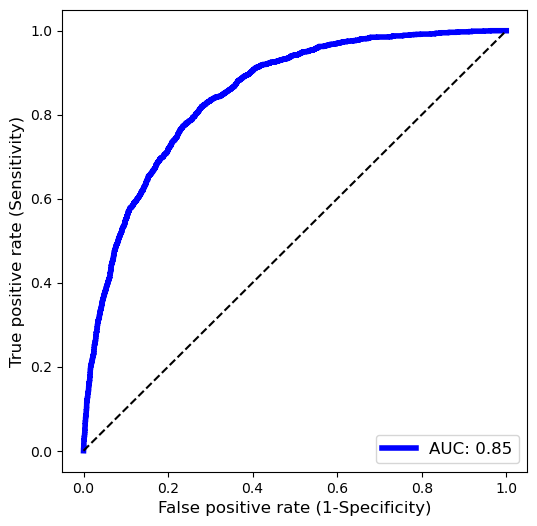

Accuracy: 0.807, Precision: 0.664, Recall: 0.554, F1: 0.604


In [33]:
#Model 2:
#Confusion matrix:
confusion1 = metrics.confusion_matrix(pred02_b, y4)
print('Confusion Matrix:\n', confusion1)

#ROC curve:
fpr, tpr, _ = metrics.roc_curve(y4, pred02)
auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (6,6))
plt.plot(fpr,tpr, linewidth = 4, color = 'blue', label = "AUC: %0.2f" % auc)
plt.plot([0, 1], [0, 1], 'k--')  # 45 degree line
plt.legend(loc = 4, fontsize = 12)
plt.ylabel("True positive rate (Sensitivity)", fontsize = 12)
plt.xlabel("False positive rate (1-Specificity)",fontsize = 12)
plt.show()

#Metrics:
accuracy = metrics.accuracy_score(y4, pred02_b)
precision = metrics.precision_score(y4, pred02_b)
recall = metrics.recall_score(y4, pred02_b)
f1 = metrics.f1_score(y4, pred02_b)
print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}')

In [37]:
#Find optimizing threshold based on F1 score for the 2 models. Use new thresholds to redo prediction and show the recall and F1 scores.

#Model 1:
probs1 = pred01_b == 1
thresholds = np.arange(0, 1, 0.001) 
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
scores = [f1_score(y1, to_labels(probs1, t)) for t in thresholds]
ix = argmax(scores)
print('Optimal Threshold = %.3f, F1-Score = %.4f' % (thresholds[ix], scores[ix]))

pred01_1 = list(map(lambda x: 1 if x > 0.001 else 0, probs1))
accuracy = metrics.accuracy_score(y1, pred01_1)
precision = metrics.precision_score(y1, pred01_1)
recall = metrics.recall_score(y1, pred01_1)
f1 = metrics.f1_score(y1, pred01_1)
print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}')

Optimal Threshold = 0.001, F1-Score = 0.6043
Accuracy: 0.807, Precision: 0.664, Recall: 0.554, F1: 0.604


In [38]:
#Model 2:
probs2 = pred02_b == 1
thresholds = np.arange(0, 1, 0.001) 
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
scores = [f1_score(y4, to_labels(probs2, t)) for t in thresholds]
ix = argmax(scores)
print('Optimal Threshold = %.3f, F1-Score = %.4f' % (thresholds[ix], scores[ix]))

pred02_1 = list(map(lambda x: 1 if x > 0.001 else 0, probs2))
accuracy = metrics.accuracy_score(y4, pred02_1)
precision = metrics.precision_score(y4, pred02_1)
recall = metrics.recall_score(y4, pred02_1)
f1 = metrics.f1_score(y4, pred02_1)
print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}')

Optimal Threshold = 0.001, F1-Score = 0.6043
Accuracy: 0.807, Precision: 0.664, Recall: 0.554, F1: 0.604


# PART C: Machine Learning Models -- Classification

In [40]:
#Import data set.
os.chdir("C:/Users/alexm/OneDrive/Desktop/UCLA Data Science Certification/Week 6/Script & Data Week 6")
titanic = pd.read_csv('Y03_titanic.csv')

In [41]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [42]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [43]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


<AxesSubplot:>

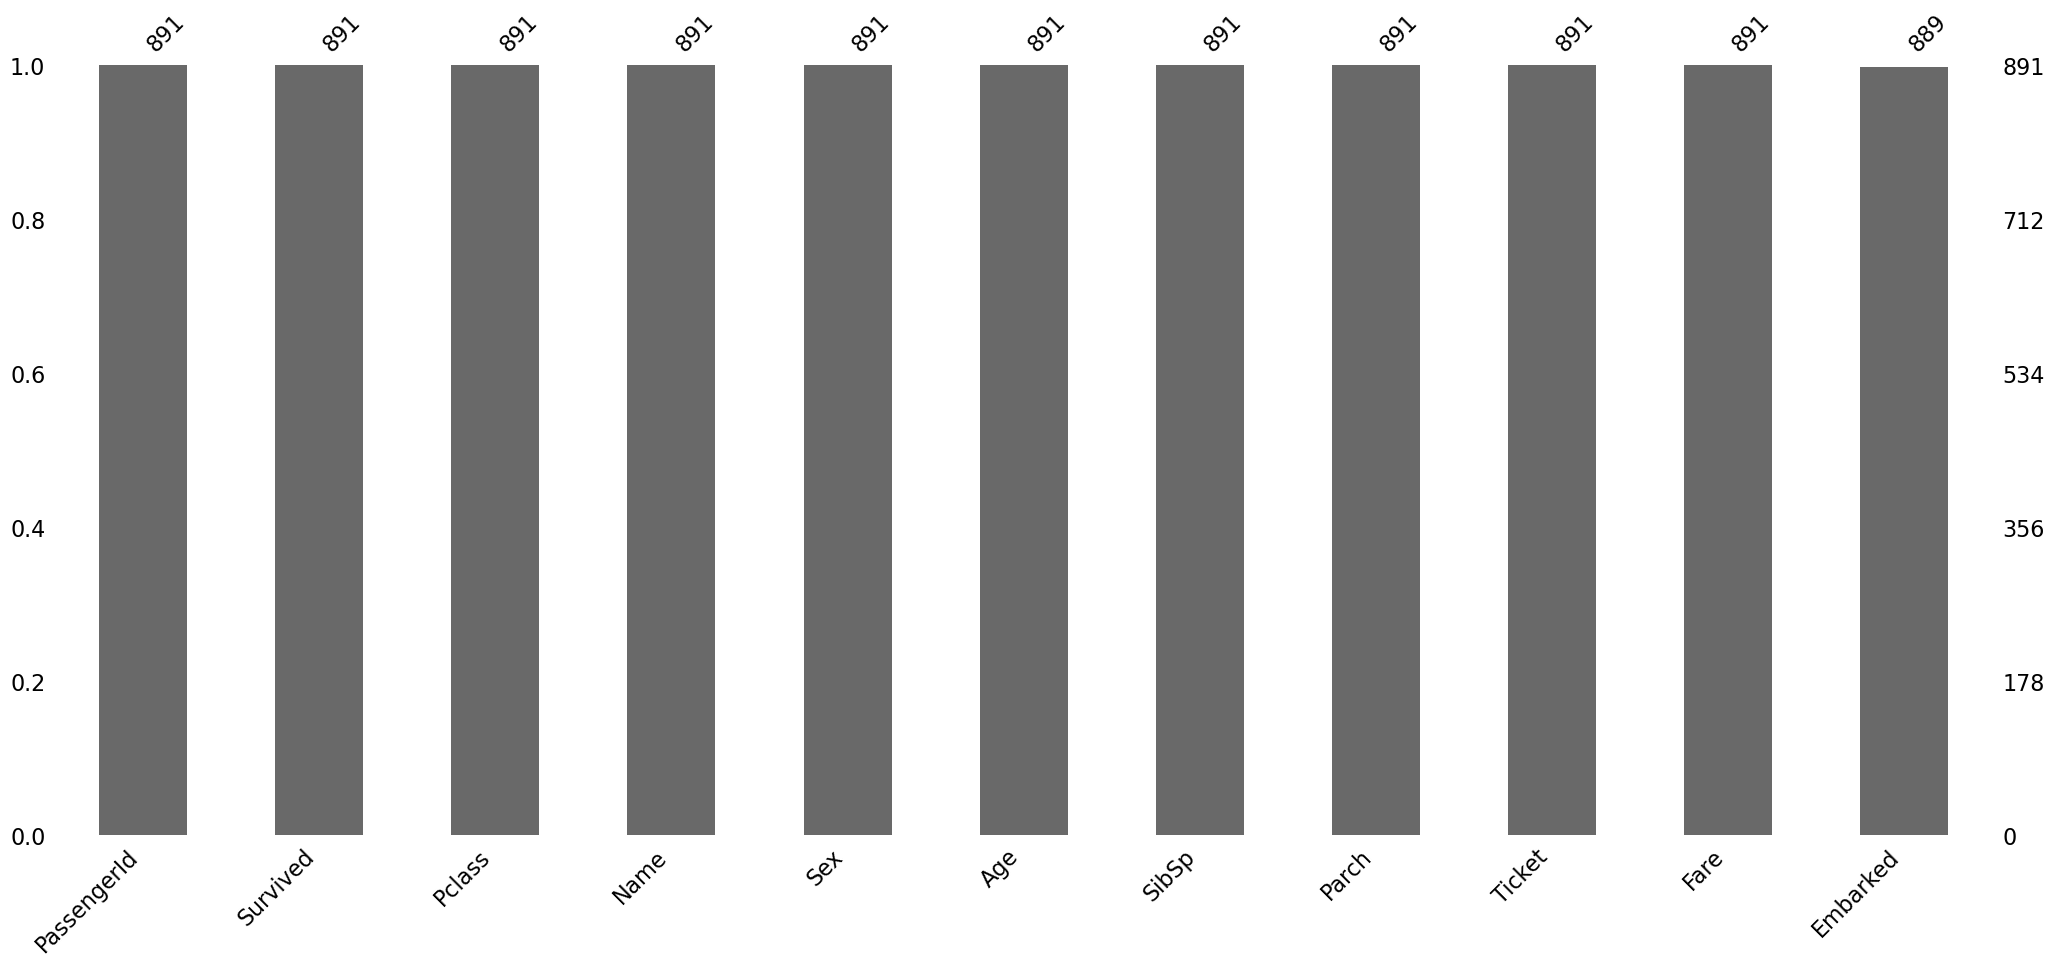

In [44]:
#Missing data management.
print(titanic.isna().sum())
titanic1 = titanic.drop("Cabin", axis = 1) #Delete Cabin variable due to high percentage of missing values.
titanic2 = titanic1.interpolate(method = 'linear') #Impute missing values in Age variable (can't due Embarked variable because it's categorical).
ms.bar(titanic2)

In [46]:
#Change object type variables in order to run XGBClassifier model.
titanic2['Sex'] = titanic2['Sex'].apply(lambda x: 1 if x == 'male' else 0)
titanic2['Embarked'] = titanic2['Embarked'].apply(lambda x: 0 if x == 'c' else (1 if x =='Q' else 2))
titanic2['Name'] = titanic2['Name'].astype('category')
titanic2['Ticket'] = titanic2['Ticket'].astype('category')

In [47]:
titanic2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    category
 4   Sex          891 non-null    int64   
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Embarked     891 non-null    int64   
dtypes: category(2), float64(2), int64(7)
memory usage: 127.0 KB


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

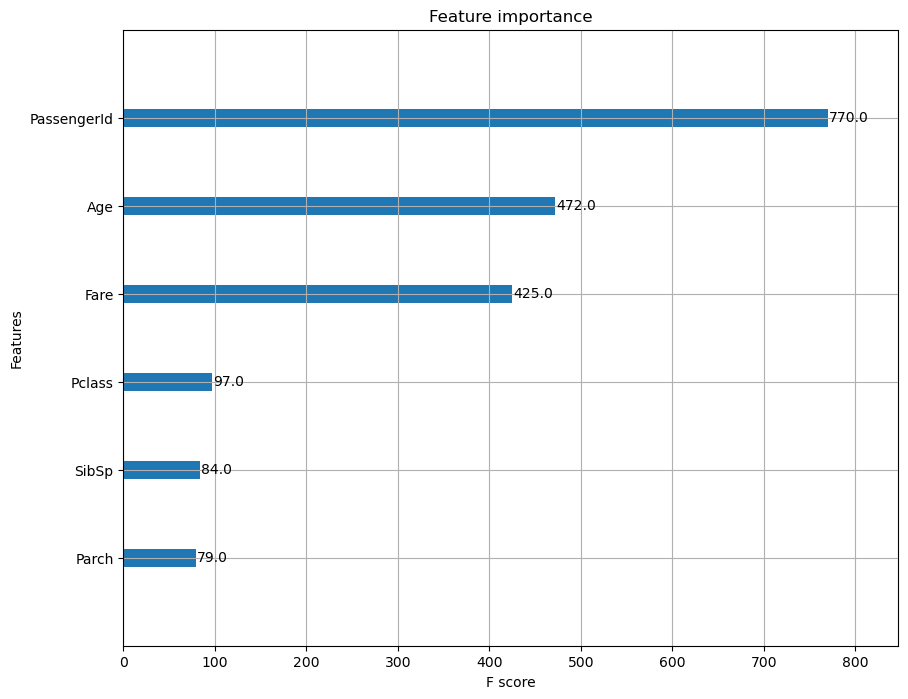

In [48]:
#Run XGBClassifier model and plot feature importance chart for XGBClassifier model.
y5 = titanic2['Survived']
X5 = titanic2.drop(['Survived', 'Name', 'Ticket'], axis = 1) 

X_train, X_test, y_train, y_test = train_test_split(X5, y5, test_size=0.3, random_state=40)
xgb01 = xgb.XGBRegressor(max_depth=5, learning_rate=0.08)
xgb01.fit(X_train, y_train)
pred07 = xgb01.predict(X_test)


fig, ax = plt.subplots(figsize = (10,8))
plot_importance(xgb01, ax = ax)

In [49]:
#Run Logit, NBayes, LDA, QDA, KNN, SVM, Tree, and RF models on Titanic data using 10-fold CV.
#Show F1, kappa, accuracy, recall, and AUC for all of the models.

y6 = titanic2['Survived'] 
X6 = titanic2.drop(columns = ['Survived', 'Name', 'Ticket'])

sc = StandardScaler()
sc.fit(X5)
X6 = sc.transform(X6)

X_train, X_test, y_train, y_test = train_test_split(X6, y6, test_size = 0.3, random_state = 40)

names = ["Logit","NBayes", "LDA", "QDA", "KNN", "SVM", "Tree", "RF", "XGB"] 

classifiers = [LogisticRegression(C=1e5), 
               GaussianNB(), 
               DA.LinearDiscriminantAnalysis(), 
               DA.QuadraticDiscriminantAnalysis(), 
               KNeighborsClassifier(n_neighbors=5), 
               SVC(kernel='linear', C=1.0, random_state = 20),
               tree.DecisionTreeClassifier(random_state=20),
               RandomForestClassifier(n_estimators=3, random_state=20),
               xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic')]

print('Model  CV    F1    Kappa Accur Recall AUC\n'+46*'-') 
for name , clf in zip(names , classifiers): 
    clf.fit(X_train , y_train) 
    y_pred = clf.predict(X_test)

    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv = cross_val_score(clf, X6, y6, scoring='roc_auc', cv=kfold)
    cv_mean = cv.mean()    

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)

    print('{:6} {:3.3f} {:3.3f} {:3.3f} {:3.3f} {:3.3f} {:3.3f}'.format(name, cv_mean, 
                                     metrics.f1_score(y_test, y_pred),
                                     metrics.cohen_kappa_score(y_test,y_pred),
                                     metrics.accuracy_score(y_test,y_pred),
                                     metrics.recall_score(y_test, y_pred),
                                     auc))

Model  CV    F1    Kappa Accur Recall AUC
----------------------------------------------
Logit  0.732 0.538 0.307 0.679 0.446 0.646
NBayes 0.712 0.543 0.309 0.679 0.455 0.648
LDA    0.732 0.538 0.307 0.679 0.446 0.646
QDA    nan 0.000 0.000 0.582 0.000 0.500
KNN    0.699 0.598 0.355 0.694 0.545 0.673
SVM    0.716 0.559 0.340 0.694 0.464 0.662
Tree   0.603 0.517 0.222 0.631 0.473 0.608
RF     0.673 0.520 0.229 0.634 0.473 0.612
XGB    0.744 0.583 0.343 0.690 0.518 0.666


In [ ]:
#The machine learning model with the highest CV is the xGBClassifier model. The CV is 0.863.